In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import caffe_classes
import matplotlib.pyplot as plt

In [2]:
def maxpool(x,KHeight,KWidth,strideX,strideY,name,padding='SAME'):
    return tf.nn.max_pool(x,ksize=[1,KHeight,KWidth,1],strides=[1,strideX,strideY,1],padding=padding,name=name)
def dropout(x,keep_prob,name=None):
    return tf.nn.dropout(x,keep_prob=keep_prob,name=name)
def LRN(x,R,alpha,beta,name=None,bias=1.0):
    return tf.nn.local_response_normalization(x,depth_radius=R,alpha=alpha,beta=beta,name=name,bias=bias)
def fc(x,inputD,outputD,useRelu,name):
    with tf.variable_scope(name) as scope:
        w = tf.get_variable("w",shape=[inputD,outputD],dtype=tf.float32)
        b = tf.get_variable("b",shape=[outputD],dtype=tf.float32)
        out = tf.nn.bias_add(tf.matmul(x,w),b)
        if useRelu:
            return tf.nn.relu(out)
        else:
            return out
def conv2d(x,KHeight,KWidth,strideX,strideY,featureNum,name,padding='SAME',groups=1):
    channel = int(x.get_shape()[-1])
    conv = lambda a, b: tf.nn.conv2d(a, b, strides = [1, strideY, strideX, 1], padding = padding)
    with tf.variable_scope(name) as scope:
        w = tf.get_variable("w", shape = [KHeight, KWidth, channel/groups, featureNum])
        b = tf.get_variable("b", shape = [featureNum])

        xNew = tf.split(value = x, num_or_size_splits = groups, axis = 3)
        wNew = tf.split(value = w, num_or_size_splits = groups, axis = 3)

        featureMap = [conv(t1, t2) for t1, t2 in zip(xNew, wNew)]
        mergeFeatureMap = tf.concat(axis = 3, values = featureMap)
        # print mergeFeatureMap.shape
        out = tf.nn.bias_add(mergeFeatureMap, b)
        return tf.nn.relu(tf.reshape(out, mergeFeatureMap.get_shape().as_list()), name = scope.name)

In [3]:
class alexNet():
    def __init__(self,x,keepPro,classNum,skip,model_path="bvlc_alexnet.npy"):
        self.X = x
        self.KEEPPRO = keepPro
        self.CLASSNUM = classNum
        self.SKIP = skip
        self.MODELPATH = model_path
        self.buildCNN()
    def buildCNN(self):
        conv1 = conv2d(self.X,11,11,4,4,96,'conv1',padding='VALID')
        lrn1 = LRN(conv1,2, 2e-05, 0.75, "norm1")
        pool1 = maxpool(lrn1,3,3,2,2,'pool1',padding='VALID')
        
        conv2 = conv2d(pool1,5,5,1,1,256,'conv2',groups=2)
        lrn2 = LRN(conv2,2, 2e-05, 0.75, "norm2")
        pool2 = maxpool(lrn2,3,3,2,2,'pool2',padding='VALID')
        
        conv3 = conv2d(pool2,3,3,1,1,384,'conv3')
        
        conv4 = conv2d(conv3,3,3,1,1,384,'conv4',groups=2)
        
        conv5 = conv2d(conv4,3,3,1,1,256,'conv5',groups=2)   
        pool5 = maxpool(conv5,3,3,2,2,'pool5',padding='VALID')
        
        pool5_flat = tf.reshape(pool5,shape=[-1,6*6*256])
        fc1 = fc(pool5_flat,6*6*256,4096,True,'fc6')
        drop1 = dropout(fc1,self.KEEPPRO)
        
        fc2 = fc(drop1,4096,4096,True,'fc7')
        drop2 = dropout(fc2,self.KEEPPRO)
        
        self.fc3 = fc(drop2,4096,self.CLASSNUM,True,'fc8')
    def loadModel(self, sess):
        """load model"""
        wDict = np.load(self.MODELPATH, encoding = "bytes").item()
        #for layers in model
        for name in wDict:
            if name not in self.SKIP:
                with tf.variable_scope(name, reuse = True):
                    for p in wDict[name]:
                        if len(p.shape) == 1:
                            #bias
                            sess.run(tf.get_variable('b', trainable = False).assign(p))
                        else:
                            #weights
                            sess.run(tf.get_variable('w', trainable = False).assign(p))

In [4]:
im = np.asarray(Image.open("faceshow.jpg").resize([227,227]))
im_true = im
im = np.expand_dims(im,axis=0)

In [5]:
keeppro = 1
classNum = 1000
skip = []

x=tf.placeholder(dtype=tf.float32,shape=[1,227,227,3])
model = alexNet(x,keeppro,classNum,skip)
score = model.fc3
softmax = tf.nn.softmax(score)
sess = tf.InteractiveSession()
model.loadModel(sess)

In [6]:
maxclass = sess.run(softmax,feed_dict={x:im})

the final class is: buckle


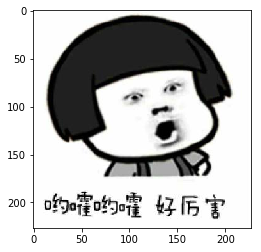

In [7]:
classidx = np.argmax(maxclass)
plt.imshow(im_true)
print("the final class is: {}".format(caffe_classes.class_names[classidx]))